In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge

from domino.data.cxr import get_dp, build_cxr_df, get_cxr_activations, rle2mask
import meerkat as mk
import pandas as pd

from scipy.stats import ttest_ind

import pydicom

# Load CXR-gaze data with Meerkat datapanel

In [2]:
# Get a mosaic DataPanel with the data.
df = build_cxr_df(root_dir="/media/4tb_hdd/siim").load() #.out(load=True)
dp = get_dp(df)
print(f"Number of rows: {len(dp)}")
dp.head()

# dp = mk.DataPanel.read(path="/media/4tb_hdd/siim/gazeslicer_dp_08-18-21.dp")
# print(len(dp))
# dp.head()

task: build_cxr_df, run_id=186
task: create_gaze_df, run_id=187
Number of rows: 12047


,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (CellColumn),img (CellColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'0',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'1',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'2',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'3',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'4',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...


In [3]:
#dp["input"].write(path="/media/4tb_hdd/siim/default_dp_08-19-21.dp")
#mk.DataPanel.write(dp,path="/media/4tb_hdd/siim/default_dp_08-19-21.dp")

In [4]:
#dp_ = mk.DataPanel.read(path="/media/4tb_hdd/siim/default_dp_08-19-21.dp")

## Gaze analysis with pneumothorax area

In [5]:
train_mask = np.array((dp["gaze_seq"].data!="nan"))
train_dp = dp[train_mask]
train_tubes = dp["chest_tube"][train_mask].data

In [6]:
train_age = np.array([int(pydicom.dcmread(img_pth).PatientAge) for img_pth in dp["filepath"][train_mask].data])
train_female = np.array([pydicom.dcmread(img_pth).PatientSex=='F' for img_pth in dp["filepath"][train_mask].data])

In [7]:
gaze_name = "gaze_time"

abn_size = np.array([rle2mask(rle,1024,1024).mean() if rle!='-1' else 0 for rle in train_dp["encoded_pixels"]])
abn_size -= abn_size.min()
abn_size /= abn_size.max()


gaze_feat = train_dp[gaze_name] 
pos_mask = train_dp["pmx"].data ==1

In [8]:
print(train_female.mean())
print(train_female[pos_mask].mean())

0.43007360672975814
0.37073170731707317


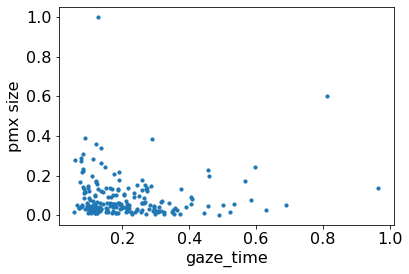

In [9]:
plt.scatter(gaze_feat[pos_mask], abn_size[pos_mask], s=10)
plt.xlabel(gaze_name)
plt.ylabel("pmx size")
plt.show()

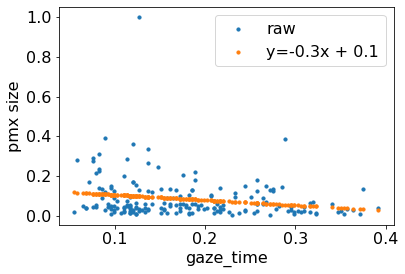

MAE: 0.063
Correlation: -0.21


In [10]:
x=gaze_feat[pos_mask]
y=abn_size[pos_mask]

# filter outliers
filtering_mask = x<0.4 #np.logical_and(train_tubes[pos_mask]==0,x<0.4)

x_ = x[filtering_mask]
y_ = y[filtering_mask]

#exponential fit
# coeffs = np.polyfit(x_,np.log(y_),1)#,w=1/(x_))
# abnsize_fit = np.exp(coeffs[1])*np.exp(coeffs[0]*x_)
coeffs = np.polyfit(x_,y_,1)
abnsize_fit = coeffs[1] + coeffs[0]*x_

plt.scatter(x_,y_,s=10)
plt.scatter(x_,abnsize_fit,s=10)
plt.xlabel(gaze_name)
plt.ylabel("pmx size")
#plt.legend(["raw",f"y={np.exp(coeffs[1]):.1f}*exp({coeffs[0]:.1f}x)"])
plt.legend(["raw",f"y={coeffs[0]:.1f}x + {coeffs[1]:.1f}"])

plt.show()

print(f"MAE: {np.abs(y_-abnsize_fit).mean():.3f}")
r = np.corrcoef(x_, y_)
print(f"Correlation: {r[0,1]:.2f}")

In [11]:
k = 50

thresh1=np.sort(x_)[k]
thresh2=np.sort(x_)[-k]
slice_mask1 = x_ < thresh1
slice_mask2 = x_ >= thresh2
print(f"Slice with time < {thresh1:.2f}, has {slice_mask1.sum()} points and an average pmx area of {y_[slice_mask1].mean():.3f}, {train_tubes[pos_mask][filtering_mask][slice_mask1].sum()} chest tubes, {train_female[pos_mask][filtering_mask][slice_mask1].sum()} females, {train_age[pos_mask][filtering_mask][slice_mask1].mean():.1f} average age, average female abn size: {y_[np.logical_and(slice_mask1,train_female[pos_mask][filtering_mask])].mean():.3f}")
print(f"Slice with time > {thresh2:.2f}, has {slice_mask2.sum()} points and an average pmx area of {y_[slice_mask2].mean():.3f}, {train_tubes[pos_mask][filtering_mask][slice_mask2].sum()} chest tubes, {train_female[pos_mask][filtering_mask][slice_mask2].sum()} females, {train_age[pos_mask][filtering_mask][slice_mask2].mean():.1f} average age, average female abn size: {y_[np.logical_and(slice_mask2,train_female[pos_mask][filtering_mask])].mean():.3f}")


Slice with time < 0.12, has 47 points and an average pmx area of 0.109, 37.0 chest tubes, 19 females, 43.3 average age, average female abn size: 0.102
Slice with time > 0.23, has 50 points and an average pmx area of 0.063, 34.0 chest tubes, 17 females, 49.7 average age, average female abn size: 0.046


In [12]:
# what is the correlation between chest tubes and abnormal area?
roc_auc_score(train_tubes[pos_mask][filtering_mask],y_)

0.48889850057670126

# Train Gaze Slicing functions

We do this by extracting the ERM image features and training a logistic regression function to differentiate between the top 2 slices

In [13]:
# get erm activations
model_pth="/home/ksaab/Documents/domino/scratch/khaled/results/method_erm/gaze_split_False/target_pmx/subgroup_none/lr_1e-05/wd_0.0/dropout_0/domino/pfr5uyh2/checkpoints/epoch=49-step=4349.ckpt"

dp_erm = get_cxr_activations(dp=dp, model_path=model_pth, run_type="domino")

dp_erm.head()

,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (CellColumn),img (CellColumn),output (ClassificationOutputColumn),activation_block3 (TensorColumn),activation_block4 (TensorColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'0',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'1',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'2',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'3',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'4',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"


In [14]:
erm_features_slicer = dp_erm["activation_block4"][train_mask][pos_mask][filtering_mask].data.reshape(-1,2048,7*7).mean(2).numpy()
X_train = np.concatenate((erm_features_slicer[slice_mask2],erm_features_slicer[slice_mask1]))
Y_train = np.array([1]*slice_mask2.sum() + [0]*slice_mask1.sum())

print(X_train.shape)
print(Y_train.shape)

clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

(97, 2048)
(97,)


In [15]:
test_mask = np.logical_and(~train_mask, ~np.isnan(dp_erm["chest_tube"]))
test_tubes = dp_erm["chest_tube"][test_mask].data

test_age = np.array([int(pydicom.dcmread(img_pth).PatientAge) for img_pth in dp["filepath"][test_mask].data])
test_female = np.array([pydicom.dcmread(img_pth).PatientSex=='F' for img_pth in dp["filepath"][test_mask].data])

pos_mask_test = dp_erm["pmx"][test_mask].data==1
erm_features_test = dp_erm["activation_block4"][test_mask].data.reshape(-1,2048,7*7).mean(2).numpy()

print(erm_features_test.shape)


slice_probs = clf.predict_proba(erm_features_test)[:,1]
test_slice_mask1 = slice_probs > 0.77 #0.98 #0.17 #0.11
test_slice_mask2 = slice_probs <= 0.77 #0.98 #0.17 #0.11

print(f"Predicted high time: {test_slice_mask1.sum()}/{len(erm_features_test)}")
print(f"Predicted low time: {test_slice_mask2.sum()}/{len(erm_features_test)}")


(1000, 2048)
Predicted high time: 352/1000
Predicted low time: 648/1000


In [16]:
abn_size_test = np.array([rle2mask(rle,1024,1024).mean() if rle!='-1' else 0 for rle in dp_erm[test_mask]["encoded_pixels"]])
abn_size_test -= abn_size_test.min()
abn_size_test /= abn_size_test.max()

In [41]:
# plt.hist(abn_size_test[test_slice_mask1],bins=100,alpha=0.5)
# plt.hist(abn_size_test[test_slice_mask2],bins=100,alpha=0.5)
# plt.show()
pos_slice_mask1 = np.logical_and(test_slice_mask1,pos_mask_test)
pos_slice_mask2 = np.logical_and(test_slice_mask2,pos_mask_test)

print(f"Predicted low time in positives: {pos_slice_mask2.sum()}/{(pos_mask_test.sum())}")
print(f"Predicted high time in positives: {pos_slice_mask1.sum()}/{(pos_mask_test.sum())}")

print(f"\nSlice with predicted low {gaze_name}, avg abn size: {abn_size_test[pos_slice_mask2].mean():.3f}, has {test_tubes[pos_slice_mask2].sum()} chest tubes, {test_female[pos_slice_mask2].sum()} females, {test_age[pos_slice_mask2].mean():.1f} average age")#, average female abn size: {abn_size_test[np.logical_and(pos_slice_mask2,test_female)].mean():.3f}")
print(f"Slice with predicted high {gaze_name}, avg abn size: {abn_size_test[pos_slice_mask1].mean():.3f}, has {test_tubes[pos_slice_mask1].sum()} chest tubes, {test_female[pos_slice_mask1].sum()} females, {test_age[pos_slice_mask1].mean():.1f} average age")#, average female abn size: {abn_size_test[np.logical_and(pos_slice_mask1,test_female)].mean():.3f}")
print(f"p-value on area: {ttest_ind(abn_size_test[pos_slice_mask1],abn_size_test[pos_slice_mask2])[1]:.4f}")

Predicted low time in positives: 125/248
Predicted high time in positives: 123/248

Slice with predicted low gaze_time, avg abn size: 0.131, has 84.0 chest tubes, 69 females, 43.8 average age
Slice with predicted high gaze_time, avg abn size: 0.098, has 98.0 chest tubes, 48 females, 48.5 average age
p-value on area: 0.0692


## Performance gaps on z and z-hat

In [36]:
def split_gaps(test_labels, test_probs, attribute, pos_low_slice,pos_high_slice, abn_size_test,neg_mask_test,pos_mask_test,gaze_name, att_name):


    print("\n"+"="*20+f" {att_name} analysis " + "="*20)
    ## remove attribute
    pos_noatt_mask = np.logical_and(pos_mask_test,np.logical_not(attribute))

    with_noatt_mask = np.logical_or(neg_mask_test,pos_noatt_mask)
    print(f"\nAll positives have NO {att_name} (# positives: {pos_noatt_mask.sum()}), AUROC: {roc_auc_score(test_labels[with_noatt_mask],test_probs[with_noatt_mask]):.2f}")



    pos_lowslice_noatt = np.logical_and(pos_low_slice,pos_noatt_mask)
    pos_highslice_noatt = np.logical_and(pos_high_slice,pos_noatt_mask)

    with_lowslice_mask = np.logical_or(neg_mask_test,pos_lowslice_noatt)
    with_highslice_mask = np.logical_or(neg_mask_test,pos_highslice_noatt)

    print(f"All positives have low {gaze_name} -- NO {att_name} (# positives: {pos_lowslice_noatt.sum()}), AUROC: {roc_auc_score(test_labels[with_lowslice_mask],test_probs[with_lowslice_mask]):.2f},    area: {abn_size_test[pos_lowslice_noatt].mean():.3f}")
    print(f"All positives have high {gaze_name} -- NO {att_name} (# positives: {pos_highslice_noatt.sum()}), AUROC: {roc_auc_score(test_labels[with_highslice_mask],test_probs[with_highslice_mask]):.2f},    area: {abn_size_test[pos_highslice_noatt].mean():.3f}")


    ## keep attribute
    pos_att_mask = np.logical_and(pos_mask_test,attribute)

    with_att_mask = np.logical_or(neg_mask_test,pos_att_mask)
    print(f"\nAll positives have {att_name} (# positives: {pos_att_mask.sum()}), AUROC: {roc_auc_score(test_labels[with_att_mask],test_probs[with_att_mask]):.2f}")


    pos_lowslice_att = np.logical_and(pos_low_slice,pos_att_mask)
    pos_highslice_att = np.logical_and(pos_high_slice,pos_att_mask)

    with_lowslice_mask = np.logical_or(neg_mask_test,pos_lowslice_att)
    with_highslice_mask = np.logical_or(neg_mask_test,pos_highslice_att)

    print(f"All positives have low {gaze_name} -- {att_name} (# positives: {pos_lowslice_att.sum()}), AUROC: {roc_auc_score(test_labels[with_lowslice_mask],test_probs[with_lowslice_mask]):.2f},    area: {abn_size_test[pos_lowslice_att].mean():.3f}")
    print(f"All positives have high {gaze_name} -- {att_name} (# positives: {pos_highslice_att.sum()}), AUROC: {roc_auc_score(test_labels[with_highslice_mask],test_probs[with_highslice_mask]):.2f},    area: {abn_size_test[pos_highslice_att].mean():.3f}")


In [39]:

test_probs = dp_erm["output"][test_mask].data[:,1].sigmoid().numpy()
test_labels = dp_erm["pmx"][test_mask].data

slice_preds = slice_probs
#abn_size_test_ = abn_size_test


print(f"Overall AUROC: {roc_auc_score(test_labels,test_probs):.2f}")

thresh = 0.77 #chosen such that we take bottom/top 50
pos_low_slice = np.logical_and(slice_preds<thresh,pos_mask_test)
pos_high_slice = np.logical_and(slice_preds>=thresh,pos_mask_test)

neg_mask_test = np.array(test_labels==0)

with_low_slice_mask = np.logical_or(neg_mask_test,pos_low_slice)
with_high_slice_mask = np.logical_or(neg_mask_test,pos_high_slice)

print(f"All positives have low {gaze_name} (# positives: {pos_low_slice.sum()}), AUROC: {roc_auc_score(test_labels[with_low_slice_mask],test_probs[with_low_slice_mask]):.2f},    area: {abn_size_test[pos_low_slice].mean():.3f}")
print(f"All positives have high {gaze_name} (# positives: {pos_high_slice.sum()}), AUROC: {roc_auc_score(test_labels[with_high_slice_mask],test_probs[with_high_slice_mask]):.2f},    area: {abn_size_test[pos_high_slice].mean():.3f}")


split_gaps(test_labels,test_probs,test_tubes,pos_low_slice,pos_high_slice,abn_size_test,neg_mask_test,pos_mask_test,gaze_name,att_name="Tubes")


split_gaps(test_labels,test_probs,test_female,pos_low_slice,pos_high_slice,abn_size_test,neg_mask_test,pos_mask_test,gaze_name,att_name="Females")

test_old = test_age > test_age.mean()
split_gaps(test_labels,test_probs,test_old,pos_low_slice,pos_high_slice,abn_size_test,neg_mask_test,pos_mask_test,gaze_name,att_name="Old")

combined_att = np.logical_and(np.logical_not(test_tubes),test_female)




Overall AUROC: 0.87
All positives have low gaze_time (# positives: 125), AUROC: 0.85,    area: 0.131
All positives have high gaze_time (# positives: 123), AUROC: 0.90,    area: 0.098

==================== Tubes analysis ====================

All positives have NO Tubes (# positives: 66), AUROC: 0.75
All positives have low gaze_time -- NO Tubes (# positives: 41), AUROC: 0.70,    area: 0.170
All positives have high gaze_time -- NO Tubes (# positives: 25), AUROC: 0.83,    area: 0.121

All positives have Tubes (# positives: 182), AUROC: 0.92
All positives have low gaze_time -- Tubes (# positives: 84), AUROC: 0.92,    area: 0.113
All positives have high gaze_time -- Tubes (# positives: 98), AUROC: 0.91,    area: 0.093

==================== Females analysis ====================

All positives have NO Females (# positives: 131), AUROC: 0.87
All positives have low gaze_time -- NO Females (# positives: 56), AUROC: 0.85,    area: 0.188
All positives have high gaze_time -- NO Females (# positives

In [21]:
best_thresh = 1
best_f1=0
for thresh in np.arange(0,1,0.05):
    f1 = f1_score(test_labels,test_probs>thresh)
    if f1 > best_f1:
        best_f1=f1
        best_thresh=thresh

print(best_f1)
print(best_thresh)
    

0.7300970873786407
0.1


In [22]:
mask_ = pos_large_area_notubes
imgs = dp_erm[test_mask][mask_]["img"]
segmasks = np.array([rle2mask(rle,1024,1024) for rle in dp_erm[test_mask][mask_]["encoded_pixels"]])
outputs_ = dp_erm[test_mask][mask_]["output"].data[:,1].sigmoid().numpy()
female = np.array([0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,1,1,0,0,0,1,0,0,1,1,1,1,1,1,0,1,0]) #pos_large_area_notubes
#female = np.array([0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0]) #pos_small_area_notubes

print(segmasks.shape)

(87, 1024, 1024)


In [23]:
ab_mask = np.logical_and(female,outputs_<best_thresh)
ab_mask2 = np.logical_and(female2,outputs_2>best_thresh)
print(abn_size_test[mask_][female].mean())
print(abn_size_test[mask_2][female2].mean())
print(f"p-value: {ttest_ind(abn_size_test[mask_2][female2],abn_size_test[mask_][female])[1]:.4f}")

ValueError: operands could not be broadcast together with shapes (33,) (87,) 

In [ ]:
# for ndx, (img, segmask, out) in enumerate(zip(imgs,segmasks, outputs_)):
#     if female[ndx] and out < best_thresh:
#         plt.imshow(img,cmap="gray")
#         plt.imshow(segmask.T,alpha=0.3)
#         plt.axis("OFF")
#         plt.title(out)
#         plt.show()

In [ ]:
mask_2 = pos_small_area_notubes
imgs2 = dp_erm[test_mask][mask_2]["img"]
segmasks2 = np.array([rle2mask(rle,1024,1024) for rle in dp_erm[test_mask][mask_2]["encoded_pixels"]])
outputs_2 = dp_erm[test_mask][mask_2]["output"].data[:,1].sigmoid().numpy()
female2 = np.array([0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0]) #pos_small_area_notubes

print(segmasks.shape)

In [ ]:
# for ndx, (img, segmask, out) in enumerate(zip(imgs2,segmasks2, outputs_2)):
#     if female2[ndx] and out > best_thresh:
#         plt.imshow(img,cmap="gray")
#         plt.imshow(segmask.T,alpha=0.3)
#         plt.axis("OFF")
#         plt.title(out)
#         plt.show()

## Mimic

In [32]:
# get mimic activations
model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/08-10_sabri_mimic/model_chkpt_runid4495.pt"
dp_mimic = get_cxr_activations(dp=dp, model_path=model_pth, run_type="mimic")


In [33]:
mimic_labels = [
    "atelectasis",
    "cardiomegaly",
    "consolidation",
    "edema",
    "enlarged_cardio",
    "fracture",
    "lung_opacity",
    "pleural_effusion",
    "pleural_other",
    "pneumonia",
    "pneumothorax",
    "support_devices",
    "lung_lesion",
    "no_finding",
]

test_mimic_probs = dp_mimic[test_mask]["output"].data.softmax(1)
test_mimic_probs[:,11] = 0 # remove support devices
test_mimic_probs[:,10] = 0 # remove pmx
test_mimic_probs[:,-1] = 0 # remove no finding

test_mimic_preds = test_mimic_probs.argmax(1)

In [ ]:
# label_mask = np.array(dp_[test_mask]["pmx"] == 0)
# slicing_pred = dp_mimic[test_mask][gaze_name]

In [ ]:
# for ndx in range(len(mimic_labels)):
#     if (test_mimic_preds[label_mask]==ndx).sum() > 50:
#         print(f"{mimic_labels[ndx]} Count: {(test_mimic_preds[label_mask]==ndx).sum()}, AUROC: {roc_auc_score(slicing_pred[label_mask],test_mimic_probs[label_mask,ndx]):.3f}")

In [ ]:
# slice_mask = np.array(slicing_pred == 1)
# mask = np.logical_and(label_mask,slice_mask)
# print(f"Overall {gaze_name} count: {slicing_pred.sum()}\n")
# for ndx in range(len(mimic_labels)):
#     print(f"{mimic_labels[ndx]} Count %: {(test_mimic_preds[mask]==ndx).sum()/mask.sum():.2f}")

## Mimic performance gaps

In [51]:

mimic_abn = np.array(test_mimic_preds==1)
#abn_size_test_ = abn_size_test


print(f"Overall AUROC: {roc_auc_score(test_labels,test_probs):.2f}")

neg_mask_test = np.array(test_labels==0)
pos_mask_test = np.array(test_labels==1)

neg_with_abn = np.logical_and(mimic_abn,neg_mask_test)
neg_without_abn = np.logical_and(np.logical_not(mimic_abn),neg_mask_test)



with_negabn = np.logical_or(pos_mask_test,neg_with_abn)
without_negabn = np.logical_or(pos_mask_test,neg_without_abn)

print(f"All negatives have mimic abn (# negatives: {neg_with_abn.sum()}), AUROC: {roc_auc_score(test_labels[with_negabn],test_probs[with_negabn]):.2f}")
print(f"All negatives dont have mimic abn(# negatives: {neg_without_abn.sum()}), AUROC: {roc_auc_score(test_labels[without_negabn],test_probs[without_negabn]):.2f}")

Overall AUROC: 0.90
All negatives have mimic abn (# negatives: 184), AUROC: 0.95
All negatives dont have mimic abn(# negatives: 568), AUROC: 0.88
